In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        labels = self.label_emb(labels)
        gen_input = torch.cat((noise, labels), dim=1)
        return self.model(gen_input)

In [15]:
class Critic(nn.Module):
    def __init__(self, input_dim, label_dim):
        super(Critic, self).__init__()
        self.label_emb = nn.Embedding(label_dim, input_dim)  # Change the size here
        self.model = nn.Sequential(
            nn.Linear(input_dim + input_dim, 512),  # Adjust the input dimension here
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, inputs, labels):
        labels = self.label_emb(labels).view(labels.size(0), -1)
        disc_input = torch.cat((inputs, labels), dim=1)
        return self.model(disc_input)

In [8]:
def gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=real_data.device)
    epsilon = epsilon.expand(real_data.size())
    interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
    interpolates.requires_grad_(True)

    # Forward pass of interpolates through the critic
    interpolated_labels = real_labels.view(batch_size, -1)
    d_interpolates = C(interpolates, interpolated_labels)

    # Create ones tensor for gradient calculation
    fake = torch.ones(d_interpolates.size(), device=real_data.device)

    # Calculate gradients of interpolates with respect to critic's prediction
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

In [10]:
def train_gan(data, labels, epochs=300, batch_size=32, noise_dim=100, lr_g=1e-4, lr_c=1e-5, lambda_gp=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    data = data.float()
    labels = labels.long()
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    G = Generator(noise_dim, 8, data.shape[1] * data.shape[2]).to(device)
    C = Critic(data.shape[1] * data.shape[2], 8).to(device)

    optimizer_g = optim.Adam(G.parameters(), lr=lr_g, betas=(0.5, 0.999))
    optimizer_c = optim.Adam(C.parameters(), lr=lr_c, betas=(0.5, 0.999))

    critic_losses = []
    generator_losses = []

    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device).view(-1, data.shape[1] * data.shape[2])
            real_labels = real_labels.to(device)

            batch_size = real_data.size(0)
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_labels = torch.randint(0, 8, (batch_size,)).to(device)
            fake_data = G(noise, fake_labels)

            real_targets = torch.ones(batch_size, 1).to(device)
            fake_targets = torch.zeros(batch_size, 1).to(device)

            # Train Critic
            optimizer_c.zero_grad()
            real_output = C(real_data, real_labels)
            fake_output = C(fake_data.detach(), fake_labels)
            gp = gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp)
            loss_c = -torch.mean(real_output) + torch.mean(fake_output) + gp
            loss_c.backward(retain_graph=True)
            optimizer_c.step()
            critic_losses.append(loss_c.item())

            # Train Generator every 5 iterations of Critic
            if i % 5 == 0:
                optimizer_g.zero_grad()
                fake_output = C(fake_data, fake_labels)
                loss_g = -torch.mean(fake_output)
                loss_g.backward(retain_graph=True)
                optimizer_g.step()
                generator_losses.append(loss_g.item())

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Critic Loss: {loss_c.item():.4f}, Generator Loss: {loss_g.item():.4f}')
            torch.save(G.state_dict(), f'generator_{epoch + 1}.pth')

    return G, C, critic_losses, generator_losses


In [13]:
# Load your data and labels from .pth files
data_user1 = torch.load('data_mm_user1.pth')  # replace with the actual path to your .pth file
labels_user1 = torch.load('labels_user1.pth')  # replace with the actual path to your .pth file

G, C, critic_losses, generator_losses = train_gan(data_user1, labels_user1)

# Plotting the losses
plt.figure(figsize=(10, 5))
plt.plot(critic_losses, label='Critic Loss')
plt.plot(generator_losses, label='Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Critic Loss and Generator Loss During Training')
plt.show()

C:\Users\devan\AppData\Local\Temp\ipykernel_36704\213613935.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_user1 = torch.load('data_mm_user1.pth')  # replace with 

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 1500 but got size 8 for tensor number 1 in the list.

C:\Users\devan\AppData\Local\Temp\ipykernel_36704\615119764.py:127: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_user1 = torch.load('data_mm_user1.pth')  # replace wit

Epoch [20/300], Critic Loss: -68301.4062, Generator Loss: -3427.8113
Epoch [40/300], Critic Loss: -70428.8984, Generator Loss: -3539.4302
Epoch [60/300], Critic Loss: -103864.5391, Generator Loss: -3935.2798
Epoch [80/300], Critic Loss: -86549.0312, Generator Loss: -3528.2603
Epoch [100/300], Critic Loss: -99498.2734, Generator Loss: 24896.8164
Epoch [120/300], Critic Loss: -164014.0625, Generator Loss: 191250.0625
Epoch [140/300], Critic Loss: -487267.3750, Generator Loss: 668906.6875
Epoch [160/300], Critic Loss: 484481.8750, Generator Loss: 1548125.0000
Epoch [180/300], Critic Loss: 3447056.0000, Generator Loss: 1459479.3750
Epoch [200/300], Critic Loss: -2958772.0000, Generator Loss: 3686372.0000
Epoch [220/300], Critic Loss: -4546203.0000, Generator Loss: 6429832.5000
Epoch [240/300], Critic Loss: -9236243.0000, Generator Loss: 9978285.0000
Epoch [260/300], Critic Loss: -4543968.0000, Generator Loss: 20134328.0000
Epoch [280/300], Critic Loss: -32913260.0000, Generator Loss: 23181

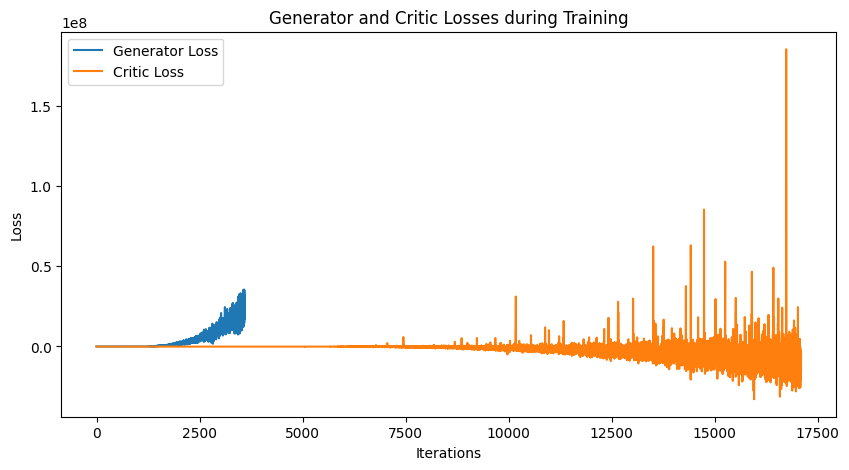

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, output_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.net = nn.Sequential(
            nn.Linear(noise_dim + label_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, output_dim),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        labels = self.label_emb(labels)
        gen_input = torch.cat((noise, labels), dim=1)
        return self.net(gen_input)

class Critic(nn.Module):
    def __init__(self, input_dim, label_dim):
        super(Critic, self).__init__()
        self.label_emb = nn.Embedding(label_dim, label_dim)
        self.net = nn.Sequential(
            nn.Linear(input_dim + label_dim, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 1)
        )

    def forward(self, inputs, labels):
        labels = self.label_emb(labels)
        inputs = inputs.view(inputs.size(0), -1)
        labels = labels.view(labels.size(0), -1)
        disc_input = torch.cat((inputs, labels), dim=1)
        return self.net(disc_input)

def gradient_penalty(critic, real_data, fake_data, real_labels, lambda_gp=10):
    batch_size = real_data.size(0)
    epsilon = torch.rand(batch_size, 1, device=real_data.device)
    interpolates = epsilon * real_data + ((1 - epsilon) * fake_data)
    interpolates.requires_grad_(True)
    
    interpolated_labels = real_labels.view(batch_size, -1)
    d_interpolates = critic(interpolates, interpolated_labels)
    fake = torch.ones(d_interpolates.size(), device=real_data.device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates,
        grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True
    )[0]
    
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty

def train_gan(data, labels, epochs=300, batch_size=32, noise_dim=100, lr=3e-4, lambda_gp=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    data = data.float()
    labels = labels.long()
    
    dataset = TensorDataset(data, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    G = Generator(noise_dim, 8, data.shape[1] * data.shape[2]).to(device)
    C = Critic(data.shape[1] * data.shape[2], 8).to(device)
    
    optimizer_g = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
    optimizer_c = optim.Adam(C.parameters(), lr=lr, betas=(0.5, 0.999))
    
    generator_losses = []
    critic_losses = []
    batches_done = 0
    
    for epoch in range(epochs):
        for i, (real_data, real_labels) in enumerate(dataloader):
            real_data = real_data.to(device).view(-1, data.shape[1] * data.shape[2])
            real_labels = real_labels.to(device)
            
            batch_size = real_data.size(0)
            noise = torch.randn(batch_size, noise_dim).to(device)
            fake_labels = torch.randint(0, 8, (batch_size,)).to(device)
            fake_data = G(noise, fake_labels)
            
            # Train Critic
            optimizer_c.zero_grad()
            real_output = C(real_data, real_labels)
            fake_output = C(fake_data.detach(), fake_labels)
            gp = gradient_penalty(C, real_data, fake_data, real_labels, lambda_gp)
            loss_c = -torch.mean(real_output) + torch.mean(fake_output) + gp
            loss_c.backward(retain_graph=True)
            optimizer_c.step()
            
            # Record Critic Loss
            critic_losses.append(loss_c.item())
            
            # Train Generator every 5 iterations of Critic
            if i % 5 == 0:
                optimizer_g.zero_grad()
                fake_output = C(fake_data, fake_labels)
                loss_g = -torch.mean(fake_output)
                loss_g.backward(retain_graph=True)
                optimizer_g.step()
                
                # Record Generator Loss
                generator_losses.append(loss_g.item())
        
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Critic Loss: {loss_c.item():.4f}, Generator Loss: {loss_g.item():.4f}')
            torch.save(G.state_dict(), f'generator_{epoch + 1}.pth')
    
    return G, C, generator_losses, critic_losses

# Load your data and labels from .pth files
data_user1 = torch.load('data_mm_user1.pth')  # replace with the actual path to your .pth file
labels_user1 = torch.load('labels_user1.pth')  # replace with the actual path to your .pth file

G, C, generator_losses, critic_losses = train_gan(data_user1, labels_user1)

# Plotting the Losses
import matplotlib.pyplot as plt

def plot_losses(generator_losses, critic_losses, epochs):
    plt.figure(figsize=(10, 5))
    plt.plot(generator_losses, label='Generator Loss')
    plt.plot(critic_losses, label='Critic Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Generator and Critic Losses during Training')
    plt.legend()
    plt.show()

plot_losses(generator_losses, critic_losses, 300)
